**DataWitness team - Zillow Price competition - notebook 01:**

This notebook contains preliminary data exploration for Zillow prize competition, from ACN DataWitness team.

**Objective** build in Python a model that predicts house prices in Los Angeles Orange county and improves the Zestimates residual error for Kaggle Zillow Price competition: https://www.kaggle.com/c/zillow-prize-1#Competition%20Overview 
**Details** This notebook uses Python3 environment based on the kaggle/python docker image: https://github.com/kaggle/docker-python. You can run it locally using JupyterHub/Anaconda, Rodeo, pyCharm IDE or your favourite Python IDE

We perform the following steps:
1. Data loading
2. Exploratory Data Analysis: cleaning, visualising, pre-processing and feature engineering
3. Modelling (several models)
4. Results and interpretation
5. Prediction

In [1]:
#Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb # ML
import matplotlib.pyplot as plt # Data visualization
import random	#random number generator
import datetime as dt
import gc
import seaborn as sns #python visualization library
import sklearn as sk # ML
from matplotlib.pyplot import show
from matplotlib.colors import ListedColormap
from ggplot import *
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from datetime import datetime
import numpy as numpy
import pylab
import calendar
from scipy import stats
from sklearn import model_selection, preprocessing
from scipy.stats import kendalltau
import warnings
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import gc

# Inputs
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Data viz
from mlens.visualization import corr_X_y, corrmat

# Model evaluation
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator
from mlens.preprocessing import EnsembleTransformer

# Ensemble
from mlens.ensemble import SuperLearner

from scipy.stats import uniform, randint

from subprocess import check_output

np.random.seed(1)


color = sns.color_palette()
np.random.seed(1)

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

color = sns.color_palette()
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

#Statistics on input files
print("\n1. Input files:\n",check_output(["ls", "../input"]).decode("utf8"))

#### DATA LOADING

#read training input files and returns data structure
def load_data():
    train_2016 = pd.read_csv('../input/train_2016_v2.csv')
    train_2017 = pd.read_csv('../input/train_2017.csv')
    
    train = pd.concat([train_2016, train_2017], ignore_index=True)
    properties = pd.read_csv('../input/properties_2017.csv')
    sample = pd.read_csv('../input/sample_submission.csv')
    
    print("Preprocessing...")
    for c, dtype in zip(properties.columns, properties.dtypes):
        if dtype == np.float64:
            properties[c] = properties[c].astype(np.float32)
            
    print("Set train/test data...")
    
    # Add Features
    # life of property
    properties['N-life'] = 2018 - properties['yearbuilt']

    properties['A-calculatedfinishedsquarefeet'] = properties['finishedsquarefeet12'] + properties['finishedsquarefeet15']

    # error in calculation of the finished living area of home
    properties['N-LivingAreaError'] = properties['calculatedfinishedsquarefeet'] / properties['finishedsquarefeet12']

    # proportion of living area
    properties['N-LivingAreaProp'] = properties['calculatedfinishedsquarefeet'] / properties['lotsizesquarefeet']
    properties['N-LivingAreaProp2'] = properties['finishedsquarefeet12'] / properties['finishedsquarefeet15']

    # Amout of extra space
    properties['N-ExtraSpace'] = properties['lotsizesquarefeet'] - properties['calculatedfinishedsquarefeet']
    properties['N-ExtraSpace-2'] = properties['finishedsquarefeet15'] - properties['finishedsquarefeet12']

    # Total number of rooms
    properties['N-TotalRooms'] = properties['bathroomcnt'] + properties['bedroomcnt']

    # Average room size
    #properties['N-AvRoomSize'] = properties['calculatedfinishedsquarefeet'] / properties['roomcnt']

    # Number of Extra rooms
    properties['N-ExtraRooms'] = properties['roomcnt'] - properties['N-TotalRooms']

    # Ratio of the built structure value to land area
    properties['N-ValueProp'] = properties['structuretaxvaluedollarcnt'] / properties['landtaxvaluedollarcnt']

    # Does property have a garage, pool or hot tub and AC?
    #properties['N-GarPoolAC'] = ((properties['garagecarcnt'] > 0) & (properties['pooltypeid10'] > 0) & (properties['airconditioningtypeid'] != 5)) * 1

    properties["N-location"] = properties["latitude"] + properties["longitude"]
    properties["N-location-2"] = properties["latitude"] * properties["longitude"]
    #properties["N-location-2round"] = properties["N-location-2"].round(-4)

    # Ratio of tax of property over parcel
    properties['N-ValueRatio'] = properties['taxvaluedollarcnt'] / properties['taxamount']

    # TotalTaxScore
    properties['N-TaxScore'] = properties['taxvaluedollarcnt'] * properties['taxamount']

    # polnomials of tax delinquency year
    properties["N-taxdelinquencyyear-2"] = properties["taxdelinquencyyear"] ** 2
    properties["N-taxdelinquencyyear-3"] = properties["taxdelinquencyyear"] ** 3

    # Length of time since unpaid taxes
    properties['N-live'] = 2018 - properties['taxdelinquencyyear']

    # Number of properties in the zip
    zip_count = properties['regionidzip'].value_counts().to_dict()
    properties['N-zip_count'] = properties['regionidzip'].map(zip_count)

    # Number of properties in the city
    city_count = properties['regionidcity'].value_counts().to_dict()
    properties['N-city_count'] = properties['regionidcity'].map(city_count)

    # Number of properties in the city
    region_count = properties['regionidcounty'].value_counts().to_dict()
    properties['N-county_count'] = properties['regionidcounty'].map(region_count)


    id_feature = ['heatingorsystemtypeid','propertylandusetypeid', 'storytypeid', 'airconditioningtypeid',
        'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'typeconstructiontypeid']
    for c in properties.columns:
        properties[c]=properties[c].fillna(-1)
        if properties[c].dtype == 'object':
            lbl = LabelEncoder()
            lbl.fit(list(properties[c].values))
            properties[c] = lbl.transform(list(properties[c].values))
        if c in id_feature:
            lbl = LabelEncoder()
            lbl.fit(list(properties[c].values))
            properties[c] = lbl.transform(list(properties[c].values))
            dum_df = pd.get_dummies(properties[c])
            dum_df = dum_df.rename(columns=lambda x:c+str(x))
            properties = pd.concat([properties,dum_df],axis=1)
            properties = properties.drop([c], axis=1)
            #print np.get_dummies(properties[c])
    
    #
    # Make train and test dataframe
    #
    train = train.merge(properties, on='parcelid', how='left')
    sample['parcelid'] = sample['ParcelId']
    test = sample.merge(properties, on='parcelid', how='left')

    # drop out ouliers
    train = train[train.logerror > -0.4]
    train = train[train.logerror < 0.418]

    train["transactiondate"] = pd.to_datetime(train["transactiondate"])
    train["Month"] = train["transactiondate"].dt.month
    train["quarter"] = train["transactiondate"].dt.quarter
    
    test["Month"] = 10
    test['quarter'] = 4

    x_train = train.drop(['parcelid', 'logerror','transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
    y_train = train["logerror"].values
    
    x_test = test[x_train.columns]
    del test, train    
    print(x_train.shape, y_train.shape, x_test.shape)
    
    return x_train, y_train, x_test

x_train, y_train, x_test = load_data()



/opt/conda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/opt/conda/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.
[MLENS] backend: threading



1. Input files:
 properties_2016.csv
properties_2017.csv
sample_submission.csv
train_2016_v2.csv
train_2017.csv
zillow_data_dictionary.xlsx



/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Preprocessing...
Set train/test data...
(164466, 145) (164466,) (2985217, 145)


**Data Quality**

**Exploratory data analysis.**
Plot distribution of transactions per month

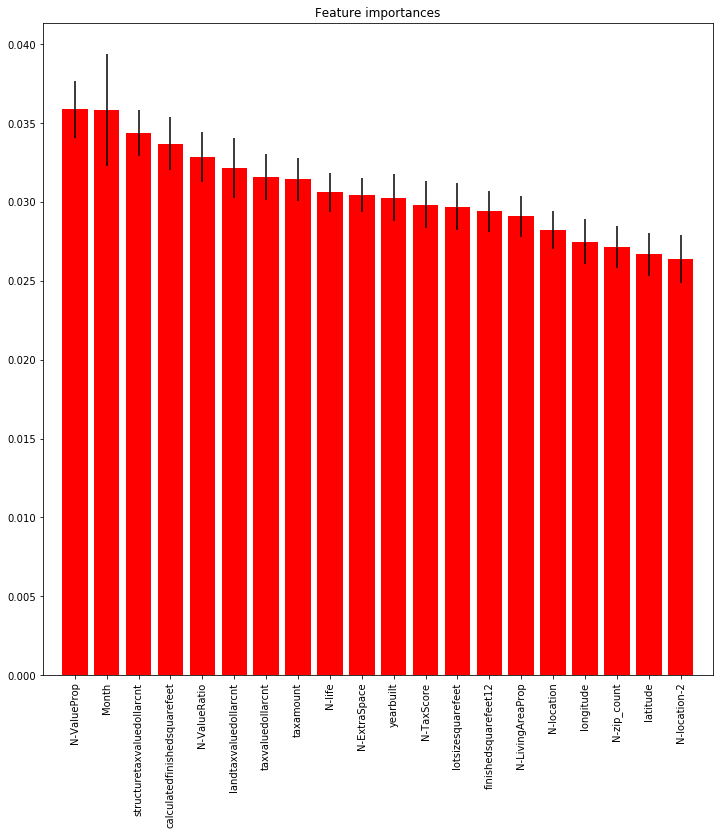

In [2]:
train_df = x_train
train_y = y_train

##Feature importance
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
#train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the feature importance ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()


**Data prep**

In [3]:
#Drop properties that are identifiers and will not have any relevance in prediction
x_train = train_df.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y_train = train_df['logerror'].values
print("\n---\n",x_train.shape, y_train.shape)

train_columns = x_train.columns

ValueError: labels ['parcelid' 'logerror' 'transactiondate'] not contained in axis

**Properties 2016:** Exploration of the actual properties from 2016 file.

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



---
number of rows x cols in train data: 

---



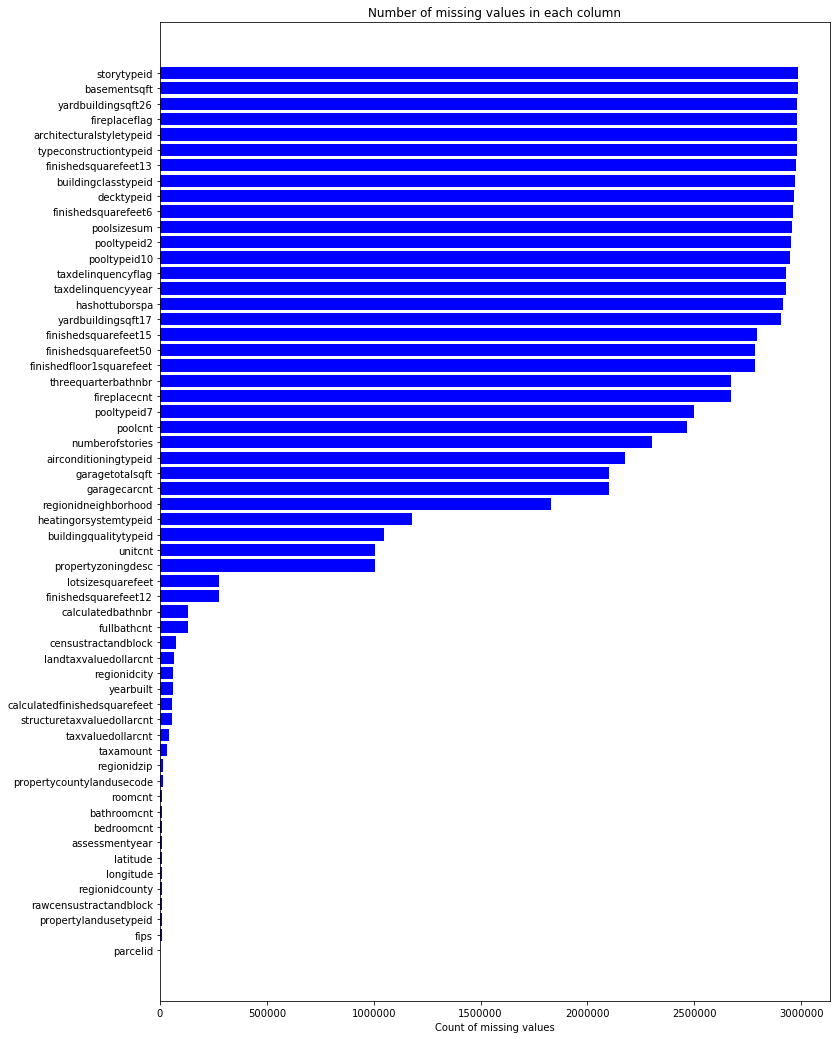

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
properties = pd.read_csv("../input/properties_2016.csv")
print("\n---\nnumber of rows x cols in train data: ")
properties.shape
print ("\n---\n")
#show first 10 rows 
properties.head(5)

missing_df = properties.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
(fig, ax) = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


**02: MODEL BUILDING**

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Training Size:(90275, 3)
Property Size:(2985217, 58)
Sample Size:(2985217, 7)
Memory usage reduction...
90053
80668
True    2365
Name: hashottuborspa, dtype: int64
1.0    1161
Name: pooltypeid10, dtype: int64
True    2365
Name: hashottuborspa, dtype: int64
1.0    1161
Name: pooltypeid10, dtype: int64
[0]	train-mae:0.480234	valid-mae:0.47887
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.342397	valid-mae:0.341188
[20]	train-mae:0.247733	valid-mae:0.246562
[30]	train-mae:0.183503	valid-mae:0.182365
[40]	train-mae:0.140447	valid-mae:0.139176
[50]	train-mae:0.112125	valid-mae:0.110831
[60]	train-mae:0.094124	valid-mae:0.092862
[70]	train-mae:0.08307	valid-mae:0.081919
[80]	train-mae:0.076595	valid-mae:0.07547
[90]	train-mae:0.072883	valid-mae:0.071722
[100]	train-mae:0.070771	valid-mae:0.069545
[110]	train-mae:0.06957	valid-mae:0.068328
[120]	train-mae:0.06888	valid-mae:0.06763

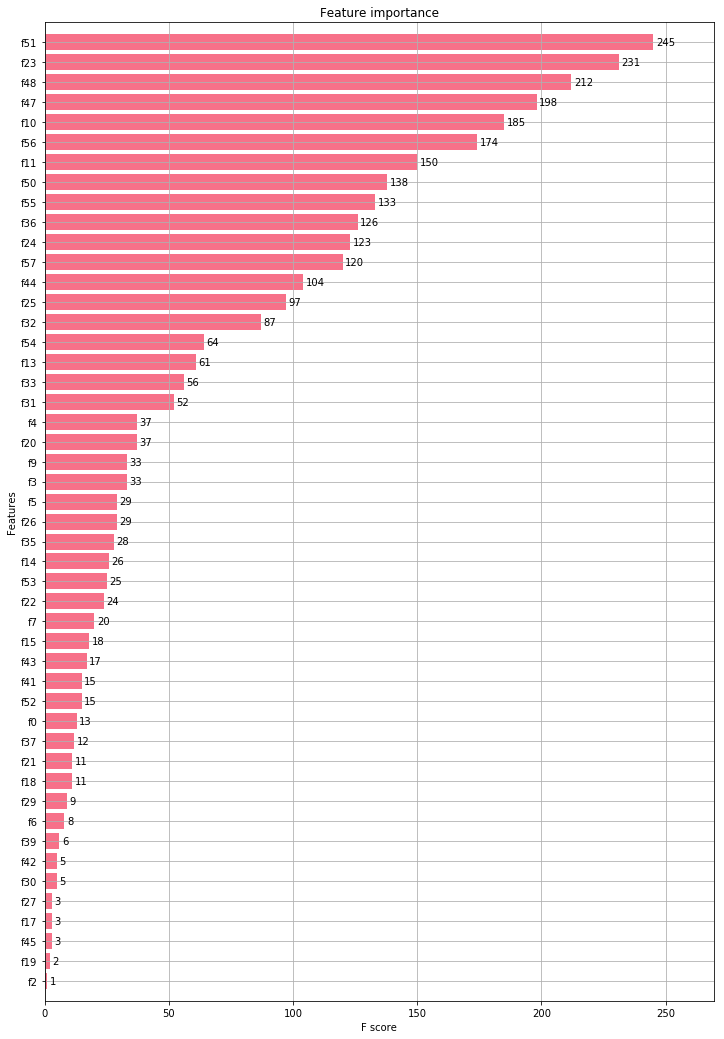

In [5]:
### Importing Libraries or Packages that are needed throughout the Program ###
import numpy as np
import pandas as pd
import xgboost as xgb
import random
import datetime as dt
import gc

import seaborn as sns #python visualization library 
color = sns.color_palette()

#%matplotlib inline
np.random.seed(1)
###Load the Datasets ###

# We need to load the datasets that will be needed to train our machine learning algorithms, handle our data and make predictions. Note that these datasets are the ones that are already provided once you enter the competition by accepting terms and conditions #

train = pd.read_csv('../input/train_2016_v2.csv' , parse_dates=["transactiondate"]) 
properties = pd.read_csv('../input/properties_2016.csv')   
test = pd.read_csv('../input/sample_submission.csv') 
test= test.rename(columns={'ParcelId': 'parcelid'}) #To make it easier for merging datasets on same column_id later


### Analyse the Dimensions of our Datasets.

print("Training Size:" + str(train.shape))
print("Property Size:" + str(properties.shape))
print("Sample Size:" + str(test.shape))

### Type Converting the DataSet ###
# The processing of some of the algorithms can be made quick if data representation is made in int/float32 instead of int/float64. Therefore, in order to make sure that all of our columns types are in float32, we are implementing the following lines of code #
for c, dtype in zip(properties.columns, properties.dtypes):
    if dtype == np.float64:        
        properties[c] = properties[c].astype(np.float32)
    if dtype == np.int64:
        properties[c] = properties[c].astype(np.int32)


for column in test.columns:
    if test[column].dtype == int:
        test[column] = test[column].astype(np.int32)
    if test[column].dtype == float:
        test[column] = test[column].astype(np.float32)


### feature engineering
#living area proportions 
properties['living_area_prop'] = properties['calculatedfinishedsquarefeet'] / properties['lotsizesquarefeet']
#tax value ratio
properties['value_ratio'] = properties['taxvaluedollarcnt'] / properties['taxamount']
#tax value proportions
properties['value_prop'] = properties['structuretaxvaluedollarcnt'] / properties['landtaxvaluedollarcnt']


###Merging the Datasets ###

# We are merging the properties dataset with training and testing dataset for model building and testing prediction #

df_train = train.merge(properties, how='left', on='parcelid') 
df_test = test.merge(properties, how='left', on='parcelid')


### Remove previos variables to keep some memory
del properties, train
gc.collect();


print('Memory usage reduction...')
df_train[['latitude', 'longitude']] /= 1e6
df_test[['latitude', 'longitude']] /= 1e6

df_train['censustractandblock'] /= 1e12
df_test['censustractandblock'] /= 1e12

### Let's do some pre-exploratory analysis to identify how much missing values do we have in our datasets. 

# Let's do some engineering with fireplaceflag variable.

print(df_train.fireplaceflag.isnull().sum())
print(df_train.fireplacecnt.isnull().sum())
# By using fireplacecnt variable we can recover some fields of fireplaceflag

df_train['fireplaceflag']= "No"
df_train.loc[df_train['fireplacecnt']>0,'fireplaceflag']= "Yes"

# Remaining Missing fireplacecnt will be replaced with 0.
index = df_train.fireplacecnt.isnull()
df_train.loc[index,'fireplacecnt'] = 0

#Tax deliquency flag - assume if it is null then doesn't exist
index = df_train.taxdelinquencyflag.isnull()
df_train.loc[index,'taxdelinquencyflag'] = "None"


# Similar step performed for Pool/Spa/hot tub
print(df_train.hashottuborspa.value_counts())
print(df_train.pooltypeid10.value_counts())

#lets remove 'pooltypeid10' as has more missing values
print(df_train.hashottuborspa.value_counts())
print(df_train.pooltypeid10.value_counts())

#Assume if the pooltype id is null then pool/hottub doesnt exist 
index = df_train.pooltypeid2.isnull()
df_train.loc[index,'pooltypeid2'] = 0

index = df_train.pooltypeid7.isnull()
df_train.loc[index,'pooltypeid7'] = 0

index = df_train.poolcnt.isnull()
df_train.loc[index,'poolcnt'] = 0

### Label Encoding For Machine Learning & Filling Missing Values ###
# We are now label encoding our datasets. All of the machine learning algorithms employed in scikit learn assume that the data being fed to them is in numerical form. LabelEncoding ensures that all of our categorical variables are in numerical representation. Also note that we are filling the missing values in our dataset with a zero before label encoding them. This is to ensure that label encoder function does not experience any problems while carrying out its operation #

from sklearn.preprocessing import LabelEncoder  

lbl = LabelEncoder()
for c in df_train.columns:
    df_train[c]=df_train[c].fillna(0)
    if df_train[c].dtype == 'object':
        lbl.fit(list(df_train[c].values))
        df_train[c] = lbl.transform(list(df_train[c].values))

for c in df_test.columns:
    df_test[c]=df_test[c].fillna(0)
    if df_test[c].dtype == 'object':
        lbl.fit(list(df_test[c].values))
        df_test[c] = lbl.transform(list(df_test[c].values))     


# Drop unuseful features and align/include same features in test as in the training set #
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 
                         'propertycountylandusecode' ], axis=1)

x_test = df_test.drop(['parcelid', 'propertyzoningdesc',
                       'propertycountylandusecode', '201610', '201611', 
                       '201612', '201710', '201711', '201712'], axis = 1) 

x_train = x_train.values
y_train = df_train['logerror'].values

### Cross Validation ###
# We are dividing our datasets into the training and validation sets so that we could monitor and the test the progress of our machine learning algorithm. This would let us know when our model might be over or under fitting on the dataset that we have employed. #

from sklearn.model_selection import train_test_split

X = x_train
y = y_train 

Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.1, random_state=47)

###Implement the Xgboost### 

# We can now select the parameters for Xgboost and monitor the progress of results on our validation set. The explanation of the xgboost parameters and what they do can be found on the following link http://xgboost.readthedocs.io/en/latest/parameter.html #

dtrain = xgb.DMatrix(Xtrain, label=ytrain)
dvalid = xgb.DMatrix(Xvalid, label=yvalid)
dtest = xgb.DMatrix(x_test.values)

# Try out different parameters
xgb_params = {'min_child_weight': 10, 'eta': 0.035, 'colsample_bytree': 0.5, 'max_depth': 4,
            'subsample': 0.85, 'lambda': 0.9, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'gamma' : 0,
            'eval_metric': 'mae', 'objective': 'reg:linear' }           

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model_xgb = xgb.train(xgb_params, dtrain, 1000, watchlist, early_stopping_rounds=100,
                  maximize=False, verbose_eval=10)

###Predicting the results###

# Let us now predict the target variable for our test dataset. All we have to do now is just fit the already trained model on the test set that we had made merging the sample file with properties dataset #

Predicted_test_xgb = model_xgb.predict(dtest)

### Submitting the Results ###

# Once again load the file and start submitting the results in each column #
sample_file = pd.read_csv('../input/sample_submission.csv') 
for c in sample_file.columns[sample_file.columns != 'ParcelId']:
    sample_file[c] = Predicted_test_xgb

print('Preparing the csv file ...')
sample_file.to_csv('xgb_predicted_results.csv', index=False, float_format='%.4f')
print("Finished writing the file")

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model_xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [6]:
#Neural Networks
from datetime import datetime
import numpy as np
import numpy as numpy
import pandas as pd
import pylab
import calendar
from scipy import stats
import seaborn as sns
from sklearn import model_selection, preprocessing
from scipy.stats import kendalltau
import warnings
import matplotlib.pyplot as plt
import pandas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

##  READ DATA  ##
# Load train, Prop and sample
#print('Loading train, prop and sample data')
#train = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
#prop = pd.read_csv('../input/properties_2016.csv')
#sample = pd.read_csv('../input/sample_submission.csv')

print('Fitting Label Encoder on properties')
for c in prop.columns:
    prop[c]=prop[c].fillna(-1)
    if prop[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(prop[c].values))
        prop[c] = lbl.transform(list(prop[c].values))
        
#Create df_train and x_train y_train from that
print('Creating training set:')
df_train = train.merge(prop, how='left', on='parcelid')

###########################################################
df_train["transactiondate"] = pd.to_datetime(df_train["transactiondate"])
df_train["transactiondate_year"] = df_train["transactiondate"].dt.year
df_train["transactiondate_month"] = df_train["transactiondate"].dt.month
df_train['transactiondate_quarter'] = df_train['transactiondate'].dt.quarter
df_train["transactiondate"] = df_train["transactiondate"].dt.day


###########################################

print('Fill  NA/NaN values using suitable method' )
df_train.fillna(-1.0)

print('Create x_train and y_train from df_train' )
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode','fireplacecnt', 'fireplaceflag'], axis=1)
y_train = df_train["logerror"]

y_mean = np.mean(y_train)
print(x_train.shape, y_train.shape)
train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)
# Create df_test and test set
print('Creating df_test  :')
sample['parcelid'] = sample['ParcelId']

print("Merge Sample with property data :")
df_test = sample.merge(prop, on='parcelid', how='left')


########################
df_test["transactiondate"] = pd.to_datetime(df_train["transactiondate"])
df_test["transactiondate_year"] = df_test["transactiondate"].dt.year
df_test["transactiondate_month"] = df_test["transactiondate"].dt.month
df_test['transactiondate_quarter'] = df_test['transactiondate'].dt.quarter
df_test["transactiondate"] = df_test["transactiondate"].dt.day     

#################################
x_test = df_test[train_columns]

print('Shape of x_test:', x_test.shape)
print("Preparing x_test:")
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)
  
from sklearn.preprocessing import Imputer
imputer= Imputer()
imputer.fit(x_train.iloc[:, :])
x_train = imputer.transform(x_train.iloc[:, :])
imputer.fit(x_test.iloc[:, :])
x_test = imputer.transform(x_test.iloc[:, :])

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


##  RUN NETWORK  ##
len_x=int(x_train.shape[1])
print("len_x is:",len_x)

####################ANN Starts here#

nn = Sequential()
nn.add(Dense(units = 360 , kernel_initializer = 'normal', activation = 'tanh', input_dim = len_x))
nn.add(Dropout(.17))
nn.add(Dense(units = 150 , kernel_initializer = 'normal', activation = 'relu'))
nn.add(BatchNormalization())
nn.add(Dropout(.4))
nn.add(Dense(units = 60 , kernel_initializer = 'normal', activation = 'relu'))
nn.add(BatchNormalization())
nn.add(Dropout(.32))
nn.add(Dense(units = 25, kernel_initializer = 'normal', activation = 'relu'))
nn.add(BatchNormalization())
nn.add(Dropout(.22))
nn.add(Dense(1, kernel_initializer='normal'))
nn.compile(loss='mae', optimizer='adam')

nn.fit(np.array(x_train), np.array(y_train), batch_size = 32, epochs = 100, verbose=2)

print("x_test.shape:",x_test.shape)
y_pred_ann = nn.predict(x_test)

#######################################################################################
print( "\nWriting predictions..." )
##  WRITE RESULTS  ##
y_pred = y_pred_ann.flatten()

#output = pd.DataFrame({'ParcelId': properties['parcelid'].astype(np.int32),
output = pd.DataFrame({'ParcelId': prop['parcelid'].astype(np.int32),
        '201610': y_pred, '201611': y_pred, '201612': y_pred,
        '201710': y_pred, '201711': y_pred, '201712': y_pred})
# set col 'ParceID' to first col
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]

print( "\nWriting results to disk:" )
output.to_csv('NN_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

print( "\nFinished!" )

Fitting Label Encoder on properties


NameError: name 'prop' is not defined

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [train, properties, test]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

NameError: name 'train' is not defined

**SUBMISSION**